# Tune a text similarity metric to best match a sample input set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
from sklearn.metrics import accuracy_score

In [2]:
df_raw = pd.read_csv("simple_names.csv", names=['names1', 'names2'])
names1 = df_raw.names1
names2 = df_raw.names2

In [3]:
def similarity_method_fuzzy_partial_ratio(a, b):
    return fuzz.partial_ratio(a, b) / 100.0

def similarity_method_fuzzy_ratio(a, b):
    return fuzz.ratio(a, b) / 100.0
    
def similarity_method_dumb(a, b):
    return float(a==b)

similarity_method = similarity_method_fuzzy_partial_ratio

def generate_similarities(names1, names2):
    truths = []
    similarities = []
    inps_names1 = []
    inps_names2 = []
    for idx1 in range(len(names1)):
        for idx2 in range(len(names2)):
            truth = idx1 == idx2
            truths.append(truth)
            similarity = similarity_method(names1[idx1], names2[idx2])
            similarities.append(similarity)
            inps_names1.append(names1[idx1])
            inps_names2.append(names2[idx2])

    df_similarities = pd.DataFrame({'truths': truths, 'similarities': similarities,
                                    'inps_names1': inps_names1, 'inps_names2': inps_names2})
    return df_similarities
df_similarities = generate_similarities(names1, names2)
df_similarities

,truths,similarities,inps_names1,inps_names2
0,True,0.87,bob builder ltd,bob builder limited
1,False,0.60,bob builder ltd,bob services ltd
2,False,0.33,bob builder ltd,alice consulting
3,False,0.33,bob builder ltd,jane and alice llp
4,False,0.40,bob builder ltd,creative outp ltd
5,False,0.50,bob services,bob builder limited
6,True,1.00,bob services,bob services ltd
7,False,0.33,bob services,alice consulting
8,False,0.33,bob services,jane and alice llp
9,False,0.17,bob services,creative outp ltd


In [4]:
df_similarities.pivot(index='inps_names1', columns='inps_names2', values='similarities')

inps_names2,alice consulting,bob builder limited,bob services ltd,creative outp ltd,jane and alice llp
inps_names1,,,,,
alice consulting,1.00,0.31,0.40,0.53,0.44
bob builder ltd,0.33,0.87,0.60,0.40,0.33
bob services,0.33,0.50,1.00,0.17,0.33
creative outputs ltd,0.50,0.32,0.44,0.82,0.33
jane & alice llp,0.44,0.31,0.38,0.39,0.81


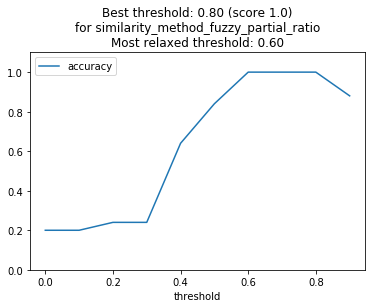

In [5]:
results = []
for threshold in np.arange(0, 1, 0.1):
    truths = df_similarities.truths
    predictions = df_similarities.similarities >= threshold
    accuracy = accuracy_score(truths, predictions)
    results.append({'accuracy': accuracy, 'threshold': threshold})
df_results = pd.DataFrame(results).set_index("threshold")
ax = df_results.plot()
# reverse the order and find the first (largest) occurrence of the threshold
# we could find the most-lenient version too
most_strict_best_threshold = df_results[::-1].accuracy.idxmax()
best_accuracy = df_results.loc[most_strict_best_threshold].accuracy
most_relaxed_best_threshold = df_results.accuracy.idxmax()

title = f"Best threshold: {most_strict_best_threshold:0.2f} (score {best_accuracy})\nfor {similarity_method.__name__}"
title += f"\nMost relaxed threshold: {most_relaxed_best_threshold:0.2f}"
ax.set_title(title);
ax.set_ylim(0, 1.1);

## Show basic diagnostics

In [7]:
mask = df_similarities.similarities >= most_strict_best_threshold
df_similarities[mask]

,truths,similarities,inps_names1,inps_names2
0,True,0.87,bob builder ltd,bob builder limited
6,True,1.00,bob services,bob services ltd
12,True,1.00,alice consulting,alice consulting
18,True,0.81,jane & alice llp,jane and alice llp
24,True,0.82,creative outputs ltd,creative outp ltd


In [8]:
print("Errors we made")
print(f"Missing true matches {df_similarities[~mask].truths.sum()}, Incorrect positive matches {(df_similarities[mask].truths==0).sum()}")

Errors we made
Missing true matches 0, Incorrect positive matches 0
